In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr, wilcoxon, ttest_ind, probplot, shapiro, chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 
from statsmodels.stats.weightstats import *
from numpy import median
import scipy
import itertools
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков.   
Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv', header = 0)

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


##### Задача 1.a (LIMIT_BAL): проверить гипотезу о равенстве медианных значений кредитного лимита для в двух группах, тех людей, кто вернул кредит и тех, кто его не вернул

Разделим данные на две части - repaid(те, кто вернули кредит), loan(те, кто кредит не вернули)

In [5]:
data['SEX'] = data['SEX'].map({1: 0, 2: 1})

In [6]:
repaid = data[data['default'] == 0]
loan = data[data['default'] == 1]

Построим гистограмму для каждой группы

No handles with labels found to put in legend.
No handles with labels found to put in legend.


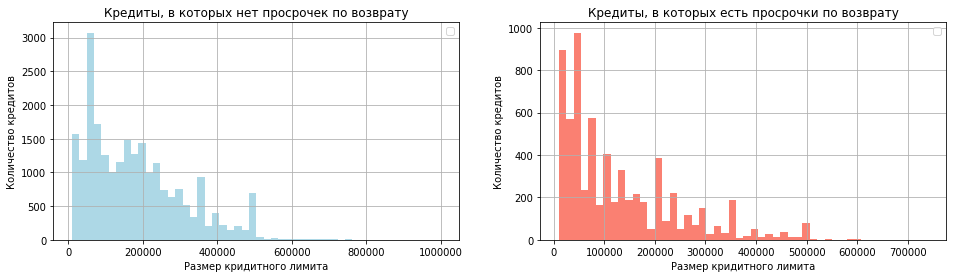

In [7]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repaid['LIMIT_BAL'].hist(bins=50,  color='lightblue')
pylab.xlabel(u'Размер кридитного лимита')
pylab.ylabel(u'Количество кредитов')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
pylab.legend()

pylab.subplot(1,2,2)
loan['LIMIT_BAL'].hist(bins = 50, color='salmon')
pylab.xlabel(u'Размер кридитного лимита')
pylab.ylabel(u'Количество кредитов')
plt.title(u'Кредиты, в которых есть просрочки по возврату')
pylab.legend()

Из графиков видно, что распределение не похоже на нормальное. Таким образом, для построения доверительного интервала для разности медиан будем использовать бустреп. Нулевая гипотеза о равестве нулю разности между медианными значениями выборок проверяется против общей альтернативы. 

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

def get_bootstrap_median_interval(data1, data2, n_samples, alpha):
    samples = []
    for i in range(n_samples):
        indices1 = np.random.randint(0, len(data1), (len(data1)))
        indices2 = np.random.randint(0, len(data2), (len(data2)))
        samples.append(median(data1[indices1]) - median(data2[indices2]))
        hist(samples)
    return stat_intervals(samples, alpha)

array([60000., 70000.])

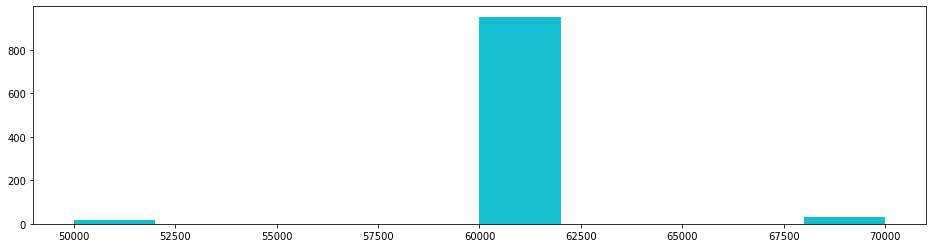

In [11]:
get_bootstrap_median_interval(repaid['LIMIT_BAL'].values, loan['LIMIT_BAL'].values, 1000, 0.05)

Гипотеза о равенстве медианных значений кредитного лимита в двух группах, тех людей, кто вернул кредит и тех, кто его не вернул отвергается, т.к. довертельный интервал для разности медионных значений не содержит нуля.

##### Задача 1.б: проверить гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Используем перестанововчный критерий для двух независимых выборок:

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [133]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [134]:
print("p-value: %f" % permutation_test(repaid['LIMIT_BAL'].values, loan['LIMIT_BAL'].values, max_permutations = 1000))

p-value: 0.001000


 0.001 < 0.05 следовательно **нулевая гипотеза** о равенстве распределение **отвергается** на уровне значимости 0.05

##### Задача 2 (SEX): Проверить гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

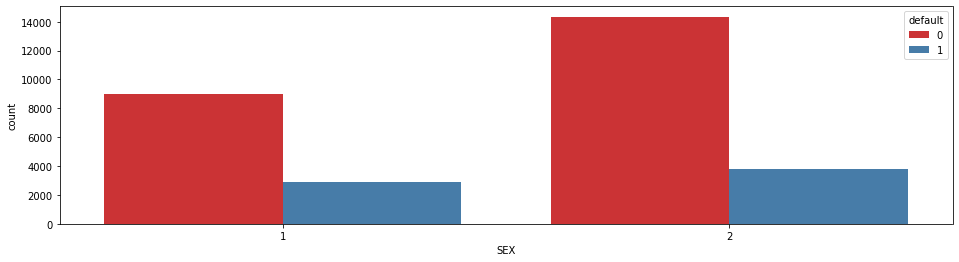

In [171]:
ax = sns.countplot(x="SEX", hue="default", data=data, palette="Set1")

In [172]:
pd.crosstab(data['SEX'], data['default'])

default,0,1
SEX,,
1,9015,2873
2,14349,3763


Проверим гипотезу о том, что доли женщин среди людей вернувших и не вернувших кредит одинаковы с помощью z-критерия для двух независимых выборок. нулевая гипотеза о равенсве нулю разности долей женщин в двух выборках проверяется против общей альтернативы.

In [173]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [174]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [175]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [176]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(repaid['SEX'], loan['SEX']))
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(repaid['SEX'], loan['SEX'])))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]
p-value:  4.472866521609831e-12


4.472866521609831e-12 < 0.05 следовательно нулевая гипотеза равенстве долей женщин среди людей вернувших и не вернувших кредит отвергается. Также ноль не попадает в доверительный интервал для разности долей, что также говорит о том, что **доли отличаются статистически значимо**. Практически же разница составляет от 3,3 до 6  процентов, что **не является практически существенно занчимым отличием**. 

##### Задача 3 (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг

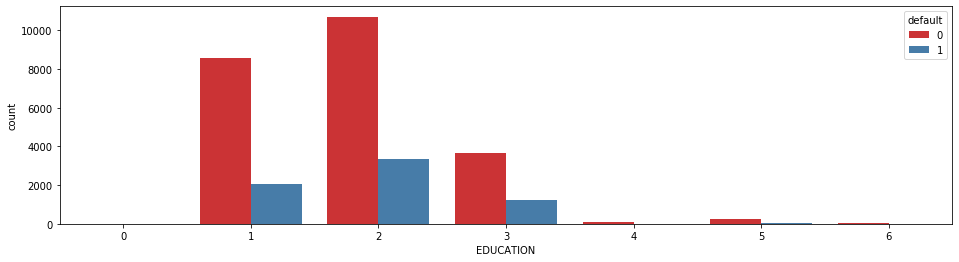

In [177]:
ax = sns.countplot(x="EDUCATION", hue="default", data=data,  palette="Set1")

Составим таблицу сопряженности "образование" на "возврат долга"

In [152]:
pd.crosstab(data['default'], data['EDUCATION'], normalize='columns').T

default,0,1
EDUCATION,,
0,1.000000,0.000000
1,0.807652,0.192348
2,0.762651,0.237349
3,0.748424,0.251576
4,0.943089,0.056911
5,0.935714,0.064286
6,0.843137,0.156863


Наилучшим индикатором того, что человек отдаст долг ялвяется наличие образования степени доктора, т.к. абсолютно все люди из нашей выборки с данным уровнем образовния вернули долг.  
Наилучшим индикатором того, что человек не вернет долг является наличие наличие образования выпускника школы. Т.к. для людей с данным образованием самая большая доля не вернувших кредит.

Проверим нулевую гипотезу о том, что признак образование и возврат кредита не зависимы с помощью критерия хи=квадрат для категориальных признаков

In [156]:
observed= pd.crosstab(data['EDUCATION'], data['default'])
chi_sq = chi2_contingency(observed)
expected = chi_sq[3]

Составим таблицу сопряженности "образование" на "возврат долга", где значения ячеек это отношени разности между наблюдаемым и ожидаемым количеством человек к наблюдаемому количсеву человек.

In [157]:
(observed - expected)

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


In [158]:
print("p-value: ", chi_sq[1])

p-value:  1.2332626245415605e-32


Гипотеза о том, что образование не влияет на то, вернет ли человек долг **уверенно отвергается** на уровне значимости 0.05

##### Задача 4(MARRIAGE): измерить взаимосвязь семейного статуса с индикатором дефолта

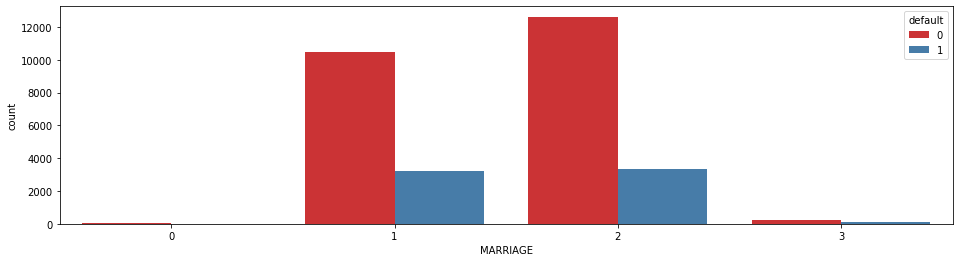

In [178]:
ax = sns.countplot(x="MARRIAGE", hue="default", data=data, palette="Set1")

В качестве меры взаимосвязи между семейным статусом и индикатором дефолта используем коэффициент  V Крамера.

In [160]:
def v_crumer(chi, k1, k2, n):
    return np.sqrt(chi/(n*(min(k1, k2)-1)))

In [162]:
chi_sq = chi2_contingency(observed)
v_cr = v_crumer(chi_sq[0], observed.shape[0], observed.shape[1], data.shape[0])
print('Коэффициент v Крамера: ', v_cr)
print("p-value: ", chi_sq[1])

Коэффициент v Крамера:  0.07376009713252163
p-value:  1.2332626245415605e-32


Значение коэффициента Крамера близко  к нолю, что говорит об отсутвии взаимосвязи между семейным статусом и фактом возврата долга. Гипотеза об отсутсвии взаимосвязи между семейным статусом и возрватом долга отвеграется.

##### Задача 5.a (AGE): проверить гипотезу о равенстве медианных значений возраста для в двух группах, тех людей, кто вернул кредит и тех, кто его не вернул

No handles with labels found to put in legend.
No handles with labels found to put in legend.


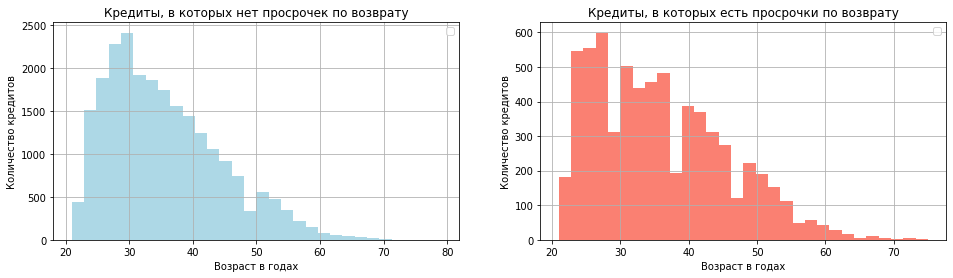

In [180]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
repaid['AGE'].hist(bins=30, color='lightblue')
pylab.xlabel(u'Возраст в годах')
pylab.ylabel(u'Количество кредитов')
plt.title(u'Кредиты, в которых нет просрочек по возврату')
pylab.legend()

pylab.subplot(1,2,2)
loan['AGE'].hist(bins = 30, color='salmon')
pylab.xlabel(u'Возраст в годах')
pylab.ylabel(u'Количество кредитов')
plt.title(u'Кредиты, в которых есть просрочки по возврату')
pylab.legend()

In [181]:
get_bootstrap_median_interval(repaid['AGE'].values, loan['AGE'].values, 1000, 0.05)

array([-1.,  0.])

Таким образом разница между медианными значениями двух выбрках включает в себя ноль, значит нельзя отвергунть нулевую гипотезу о том, что медианные значения выборок равны.

##### Задача 1.б: проверить гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Используем перестанововчный критерий для двух независимых выборок.

In [182]:
print("p-value: %f" % permutation_test(repaid['AGE'].values, loan['AGE'].values, max_permutations = 1000))

p-value: 0.009000


Нулевая гипотеза о равевенстве распределений в выборках отвергается на уровне значимости 0.05, тем не менее отличия не являются практически значимыми.